<a href="https://colab.research.google.com/github/adeepH/OLD-Shared-Task/blob/main/Bert%2BbiLSTM_Malayalam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install transformers==3.3.1

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
train=pd.read_csv('/content/mal_full_offensive_train.tsv', header=None, names=['tweets','label'], sep="\t")
train['labels']=LabelEncoder().fit_transform(train['label'])
train=train.drop(columns='label')
train

,tweets,labels
0,പലദേശം. പല ഭാഷ ഒരേ ഒരു രാജാവ് അല്ലാതെ സ്വന്ത...,0
1,ഈ ഓണം ഏട്ടനും പിള്ളേർക്ക് ഉള്ളതാണ് എന്ന് ഉള്ളവ...,0
2,ആരണ്ട ആരണ്ട തലുണ്ടാകാണാ ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്...,0
3,Sushin syam Shaiju khalid Midhun manual,0
4,J A K E S. B EJ O Y !!!,0
...,...,...
16005,കട്ട ലാലേട്ടൻ ഫാൻസിന് ദൈവത്തെ ഓർത്ത് അമിത പ്രത...,0
16006,ente mammookka ningal puliyalla oru simhama......,0
16007,Lucifer mass dialogues Ellam onnu comment chey...,0
16008,Like from Madurai (Tamil nadu) ....,4


In [11]:
val=pd.read_csv('/content/mal_full_offensive_dev.tsv', header=None, names=['tweets','label'], sep="\t")
val['labels']=LabelEncoder().fit_transform(val['label'])
val=val.drop(columns='label')
val

,tweets,labels
0,Gopichettante BGM um mammookayum ishtapedunnav...,0
1,ഇത് ഒരു പെണ്ണ് തന്നെ ആണോ direct ചെയ്യുന്നത് p...,0
2,പൃഥ്വിരാജ് സുരാജേട്ടൻ ലാലും അലക്സ്.. Lal jr. ന...,0
3,പോകരുത് മക്കളെ പോക്ക .......... നൻ കണ്ട് എന്റ്...,0
4,avan Varum ente Makan Madhura Raja....,0
...,...,...
1994,Onnam ഇട്ടി മണി & brathors ഡേ വിന്നർ ലാലേട്ടൻ ...,0
1995,Manju chechi undel hero vendaa. Chechi vere le...,0
1996,Ith kollaaaam....kanda ooodayp trailer ne kalu...,0
1997,Ufffff. Pwoli lalattaa... Katta waiting,0


In [12]:

import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [13]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (16010, 2)
validation set size: (1999, 2)


In [14]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([ 0.22624179, 22.87142857, 13.39748954, 16.76439791,  2.48795649])

In [15]:

def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweets.to_numpy(),
      label = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [16]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [17]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [18]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [19]:
import torch
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('bert-base-multilingual-uncased')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

In [20]:
model = RFClassifier(5)
model = model.to(device)

In [21]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [22]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-multilingual-uncased.bin')
    best_accuracy = val_acc

Epoch: 01 | Epoch Time: 6m 44s
Train Loss 0.4421314148607844 accuracy 0.9119925046845722
Val Loss 0.2766893393700085 accuracy 0.9344672336168084

Epoch: 02 | Epoch Time: 6m 47s
Train Loss 0.2806156716512111 accuracy 0.9391005621486571
Val Loss 0.2473115792113637 accuracy 0.9469734867433717

Epoch: 03 | Epoch Time: 6m 48s
Train Loss 0.25116352957790483 accuracy 0.9499063085571517
Val Loss 0.2462161879927393 accuracy 0.9494747373686843

Epoch: 04 | Epoch Time: 6m 47s
Train Loss 0.2364971341189748 accuracy 0.9531542785758901
Val Loss 0.23621318891407952 accuracy 0.952976488244122

Epoch: 05 | Epoch Time: 6m 47s
Train Loss 0.22775925379506723 accuracy 0.9564647095565272
Val Loss 0.23825935067401993 accuracy 0.9539769884942471

Epoch: 06 | Epoch Time: 6m 47s
Train Loss 0.2184648988192191 accuracy 0.9583385384134916
Val Loss 0.23146002716015254 accuracy 0.9549774887443722

Epoch: 07 | Epoch Time: 6m 47s
Train Loss 0.20476222746520342 accuracy 0.9581511555277951
Val Loss 0.22057005440786717 a

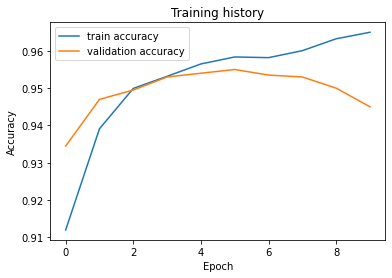

In [26]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [27]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.9449724862431215

In [28]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [29]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [30]:
class_name = ['Not_offensive' ,'Offensive_Untargetede' ,'Offensive_Targeted_Insult_Group' ,
'Offensive_Targeted_Insult_Individual' ,'not-malayalam' ]

In [31]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

                                      precision    recall  f1-score   support

                       Not_offensive       0.97      0.97      0.97      1779
               Offensive_Untargetede       0.00      0.00      0.00        13
     Offensive_Targeted_Insult_Group       0.00      0.00      0.00        24
Offensive_Targeted_Insult_Individual       0.20      0.40      0.26        20
                       not-malayalam       0.86      0.90      0.88       163

                            accuracy                           0.94      1999
                           macro avg       0.41      0.46      0.42      1999
                        weighted avg       0.94      0.94      0.94      1999



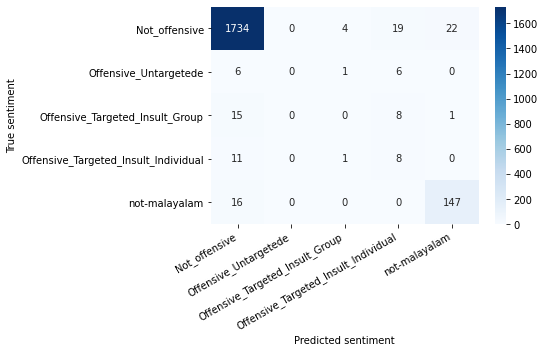

In [32]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)